In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Please use `cd` command to change the directory to the folder containing this notebook file.

In [185]:
cd /content/drive/MyDrive/Colab Notebooks/CIS581/CIS_5810_Project_2_Canny_Edge_Student_Files_V2.5

/content/drive/MyDrive/Colab Notebooks/CIS581/CIS_5810_Project_2_Canny_Edge_Student_Files_V2.5


In [186]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import platform
from scipy import signal
from PIL import Image
import argparse

# Check version of python to load helper function
assert platform.python_version() == "3.10.12", "Please contact teaching staff to re-compile helper.pyc!"

# import helper functions
import helper

# Tests and Visualization function

Testing and visualization functions. Please execute this cell before moving to next part and do NOT to modify those functions.

In [187]:
'''
Test output correctness. Do not modify
'''
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]
    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size
    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass


'''
  Derivatives visualzation function. Do not modify
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')

    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1])
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )


'''
  Edge detection result visualization function. Do not modify
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off")
    ax2.set_title('Canny Edge Detection')


'''
  Convert RGB image to gray one manually. Do not modify
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray


'''
Canny edge detection main function. Do not modify
'''
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)
    # Find gradient and perform NMS and edge linking
    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = helper.edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)
        plt.show()

    return E

In [188]:
'''
interpolation function. Do not modify
'''
def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

# Canny edge detection implementation

In this part, you will need to implement the first three steps in Canny Edge detection, including *Finding Image Gradient* and *Non Maximum Suppression (NMS)*.

In [ ]:
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of image gradient
        - Output Magx: H x W matrix represents the magnitude of image gradient along x-axis
        - Output Magy: H x W matrix represents the magnitude of image gradient along y-axis
        - Output Ori: H x W matrix represents the orientation of image gradient
    '''
    # 1. Define Gaussian G and image gradient kernel dx and dy
    G = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]])/159.0
    dx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    dy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])


    # 2. Convolve Gaussian kernel with image gradient kernel to get Gx and Gy
    Gx = signal.convolve2d(G,dx,'same')
    Gy = signal.convolve2d(G,dy,'same')

    # 3. Convolve image with Gx and Gy to get image gradient along x and y direction
    Magx = signal.convolve2d(I_gray,Gx,'same')
    Magy = signal.convolve2d(I_gray,Gy,'same')

    # 4. Compute edge gradient magnitude Mag and gradient direction Ori
    Mag = np.sqrt(Magx**2 + Magy**2)
    Ori = np.arctan2(Magy, Magx);

    return Mag, Magx, Magy, Ori

In [ ]:
## Test ##
I = plt.imread('Images/I1.jpg')
Mag, Magx, Magy, Ori = findDerivatives(I)
assert np.allclose(Mag, np.load('Mag.npy'))
assert np.allclose(Magx, np.load('Magx.npy'))
assert np.allclose(Magy, np.load('Magy.npy'))
assert np.allclose(Ori, np.load('Ori.npy'), atol=8)

In [ ]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the image gradient
        - Input Ori: H x W matrix represents the orientation of image gradient
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    # 1. Get neighbor pixels' y and x indexes
    h = Mag.shape[0]
    w = Mag.shape[1]
    M = np.zeros((h,w))
    ang = Ori
    ang[np.where(ang<0)] = np.pi + ang[np.where(ang<0)]
    x,y = np.meshgrid(np.arange(0,w,1),np.arange(0,h,1))
    x1 = x + np.cos(Ori)
    y1 = y + np.sin(Ori)
    x2 = x - np.cos(Ori)
    y2 = y - np.sin(Ori)


    # 2. Get neighbor pixels' value with interpolation
    neighbor1 = interp2(Mag, x1, y1)
    neighbor2 = interp2(Mag, x2, y2)
    neighbor1[np.where((x1 < 0) | (x1>w-1) | (y1 < 0) | (y1>h-1))] = 0
    neighbor2[np.where((x2 < 0) | (x2>w-1) | (y2 < 0) | (y2>h-1))] = 0


    # 3. Comparing with neighbor pixels and generate binary map
    M = (Mag > neighbor1) & (Mag > neighbor2)

    return M

In [ ]:
## Test ##
Mag = np.array([[0, 2, 12, 16],
                [4, 9, 11, 8],
                [7, 17, 12, 9],
                [0, 19, 21, 17]])
Ori = np.array([[np.pi/2, np.pi/4,       0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4,       0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])

res = np.array([[False, False, False,  True],
                [False, False,  True, False],
                [False,  True, False, False],
                [False,  True,  True,  True]])
M = nonMaxSup(Mag, Ori)
assert M.dtype == bool
assert M.shape == Mag.shape
assert np.allclose(M, res)

# Canny Edge Detection Visualization

## Simple image test cases
First, let's visualize the expected Canny Edge detection result on two simple images under `Simple_test_images/` directory: `coins.png` and `rotated_checkerboard.jpg`



Text(0.5, 1.0, 'Coins edges')

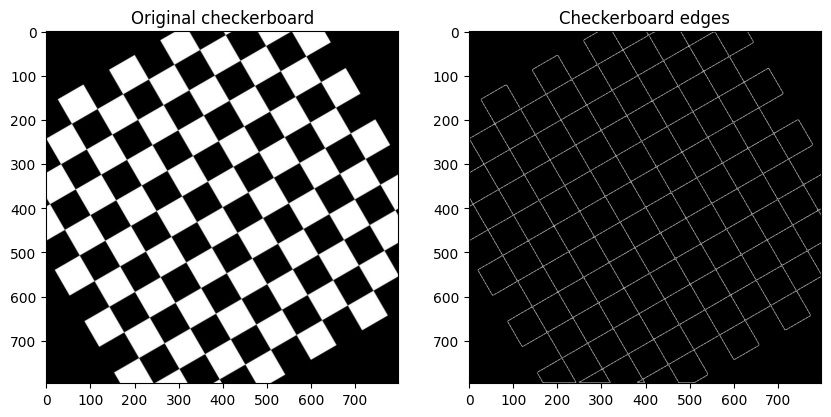

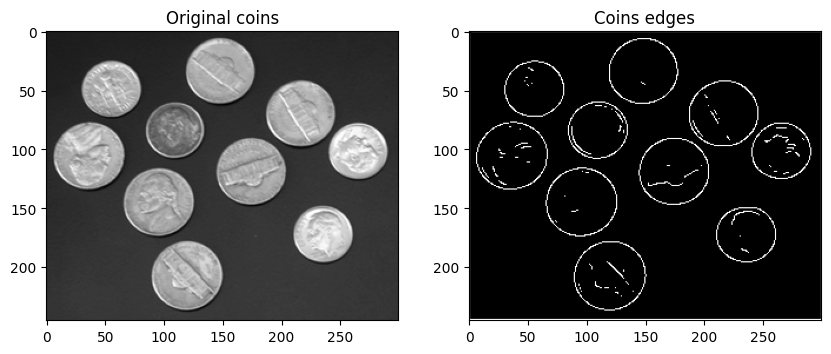

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
I_checkerboard = plt.imread('Test_Images/rotated_checkerboard.jpg')
I_checkerboard_result = plt.imread('Test_Images/rotated_checkerboard_Result.png')
ax1.imshow(I_checkerboard, cmap='gray')
ax1.set_title('Original checkerboard')
ax2.imshow(I_checkerboard_result, cmap='gray')
ax2.set_title('Checkerboard edges')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
I_coin = plt.imread('Test_Images/coins.png')
I_coin_result = plt.imread('Test_Images/coins_Result.png')
ax1.imshow(I_coin, cmap='gray')
ax1.set_title('Original coins')
ax2.imshow(I_coin_result, cmap='gray')
ax2.set_title('Coins edges')

Now, let's try to generate the edges result for both checkerboard and coins images using your implemented functions. Adjust the low and high threshold values below until the result becomes reasonable to you. The final result doesn't have to be exactly the same as the one shown above, but they should have a high similarity.

Shape Test Passed! 



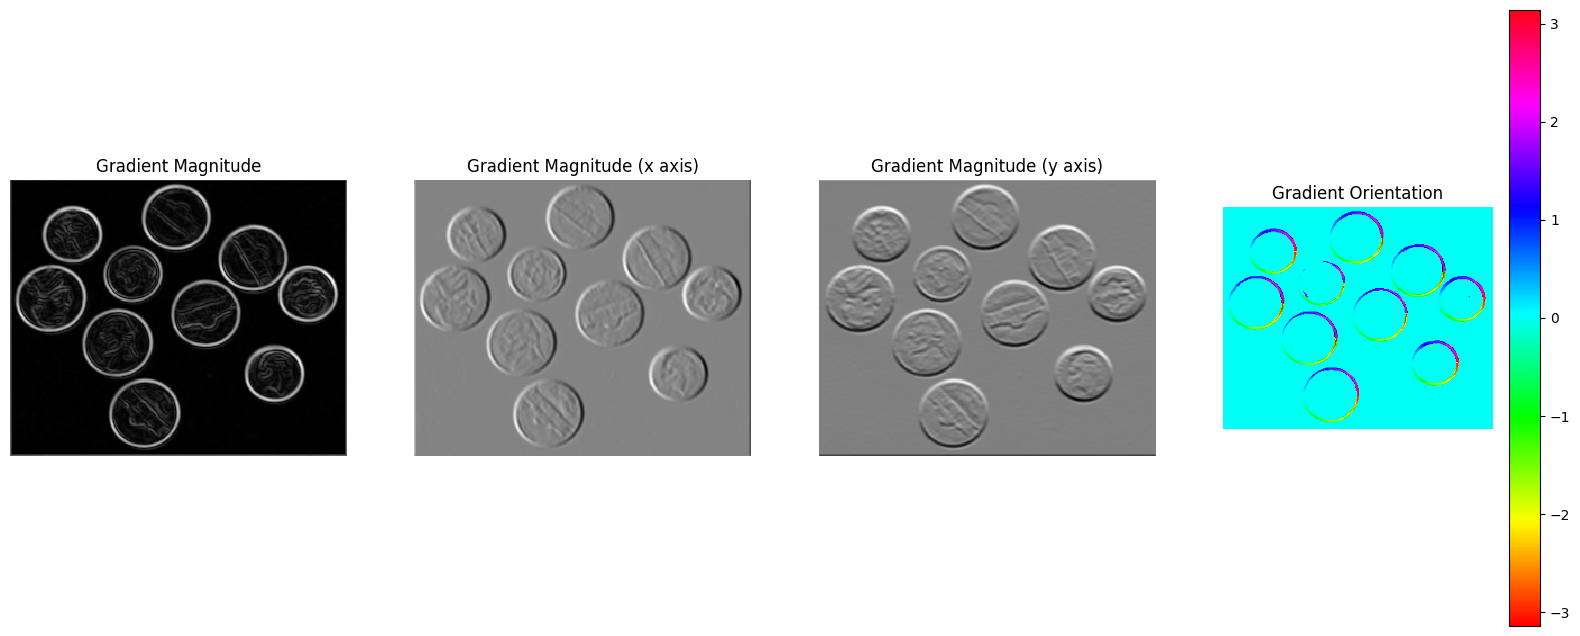

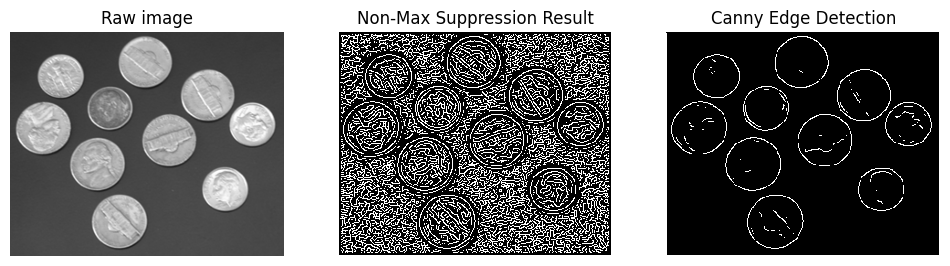

In [ ]:
# TODO: Change image name
filename = 'coins.png'

# TODO: Change threshold values
low, high = 40, 80

# tuning threshold for simple test images
image_folder = "Test_Images"
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
os.makedirs("Results", exist_ok=True)
pil_image.save(os.path.join('Results', "{}_Result.png".format(filename.split(".")[0])))

## Tune the threshold for all images under "Image" folder
In this part, we are trying to find out the proper low and high threshold values for all images under the `Images/` folder. You can execute the code cell below to print out all image file names.

To find out each image's best possible low and high threshold value, you can iteratively change the filename and try different low and high threshold values. The Canny edge results would be visualized for your reference to determine whether your entered threshold value is good or not. After you find a proper threshold value for one image, remember to fill it in `thresh_dict` dictionary for final image save.

In [ ]:
# list all image names
os.listdir('Images')

['55067.jpg',
 '135069.jpg',
 '3096.jpg',
 '16068.jpg',
 '86000.jpg',
 'I1.jpg',
 '22013.jpg',
 '118035.jpg',
 '21077.jpg',
 '201080.jpg',
 '189080.jpg',
 '48017.jpg']

Shape Test Passed! 



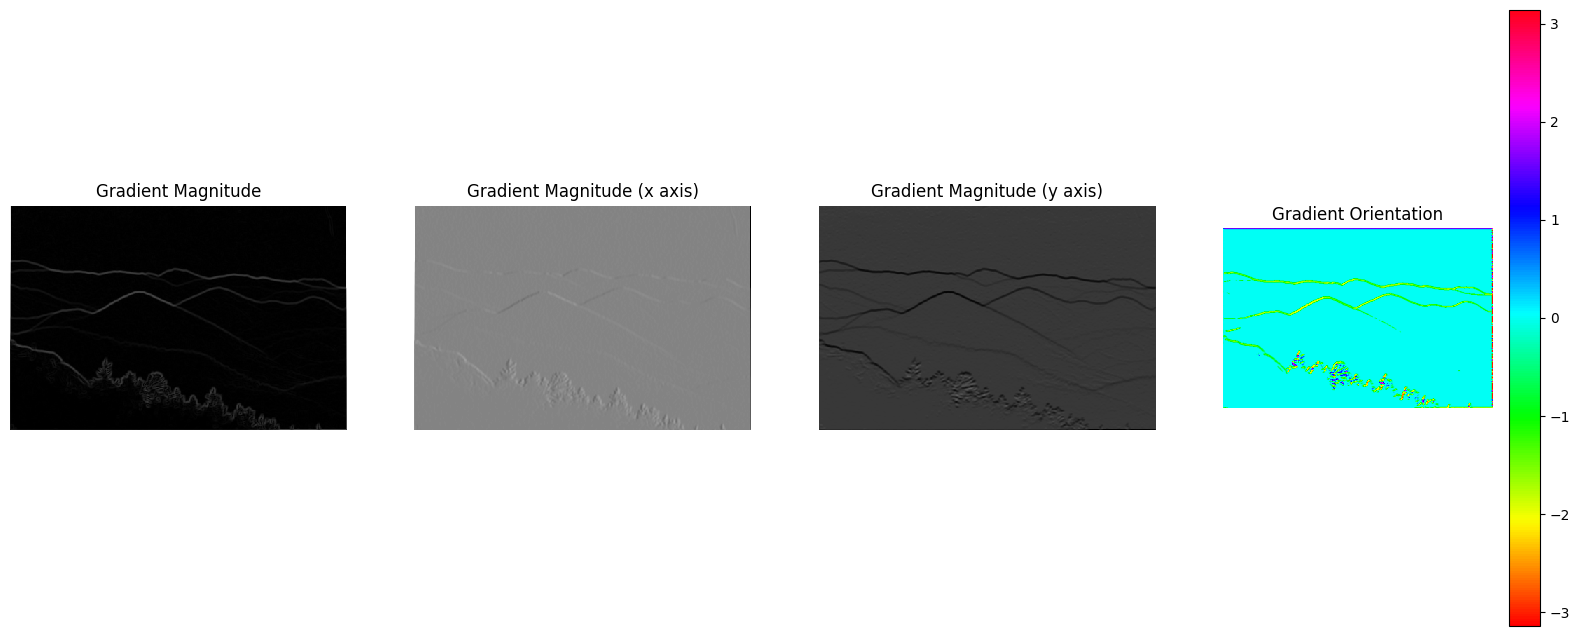

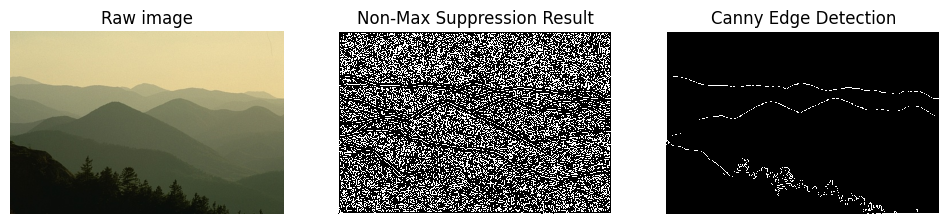

In [200]:
# TODO: Change image name
filename = '55067.jpg'

# TODO: Change threshold values
low, high = 12, 30

# Find tuning threshold for a single image
I = np.array(Image.open(os.path.join("Images", filename)).convert('RGB'))
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

## Generate edge detection visualization for all images under `Images/` directory


In [201]:
# TODO: Fill in the threshold (low, high) you have tuned in the cell above
thresh_dict = {'118035.jpg': (5, 12),
                '135069.jpg': (16, 40),
                '16068.jpg': (36, 90),
                '189080.jpg': (36, 90),
                '201080.jpg': (36, 90),
                '21077.jpg': (48, 120),
                '22013.jpg': (40, 100),
                '3096.jpg': (24, 60),
                '48017.jpg': (60, 150),
                '55067.jpg': (12, 30),
                '86000.jpg': (24, 60),
                'I1.jpg': (12, 30)}

# keep results for all images
image_folder = "Images"
save_folder = "Results"

# generate results one by one
for filename in os.listdir(image_folder):
    # read in image
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))
    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)
    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

Output hidden; open in https://colab.research.google.com to view.